In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sqlite3
from pathlib import Path 

PROJECT_ROOT = Path.cwd().parent

DATA = 'churn.db'

conn = sqlite3.connect(DATA)


query =  """
SELECT * 

FROM customer_churn_raw
"""

df = pd.read_sql(query, conn)

# Overview of data

In [23]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [24]:
print(f"Number of NaN values: {df.isna().sum().sum()}")
df.dtypes

Number of NaN values: 5174


CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

In [25]:
df.isna().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

### The only column with NaN value is Churn reason.

The remaining reasons will be used to investigate key factors causing customers to churn.

# Preprocessing

In [26]:
df.select_dtypes(include=['float64', 'int64']).corr()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zip Code,NaN,1.000000,0.895743,-0.784271,0.001041,-0.004596,0.003346,-0.002769,-0.003562
Latitude,NaN,0.895743,1.000000,-0.876779,-0.001631,-0.019899,-0.003384,-0.007684,0.000886
Longitude,NaN,-0.784271,-0.876779,1.000000,-0.001678,0.024098,0.004594,0.004260,0.000485
Tenure Months,NaN,0.001041,-0.001631,-0.001678,1.000000,0.247900,-0.352229,-0.224987,0.396406
Monthly Charges,NaN,-0.004596,-0.019899,0.024098,0.247900,1.000000,0.193356,0.133754,0.098693
Churn Value,NaN,0.003346,-0.003384,0.004594,-0.352229,0.193356,1.000000,0.664897,-0.127463
Churn Score,NaN,-0.002769,-0.007684,0.004260,-0.224987,0.133754,0.664897,1.000000,-0.079782
CLTV,NaN,-0.003562,0.000886,0.000485,0.396406,0.098693,-0.127463,-0.079782,1.000000


Count - Need to be removed from the dataset, as it does not provide any valueable information

Churn Score - High correlated with Churn Value. The prediction made by a different model (IBM SPSS), this column will be removed to avoid data leakage during modelling. 

CLTV - Will also be removed for modelling 

Longitude & Latituude & Lat Long - Will also be removed, as it is just geographical information which does not help for predicting customer churn. However these will be used for analysing. 

In [27]:
df_orig = df.copy()

# Dropping the columns 
df = df.drop(columns=['Count', 'Churn Score', 'CLTV', 'Longitude', 'Latitude', 'Lat Long'])
df.head(5)

,CustomerID,Country,State,City,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,United States,California,Los Angeles,90003,Male,No,No,No,2,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,United States,California,Los Angeles,90005,Female,No,No,Yes,2,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,United States,California,Los Angeles,90006,Female,No,No,Yes,8,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,United States,California,Los Angeles,90010,Female,No,Yes,Yes,28,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,United States,California,Los Angeles,90015,Male,No,No,Yes,49,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


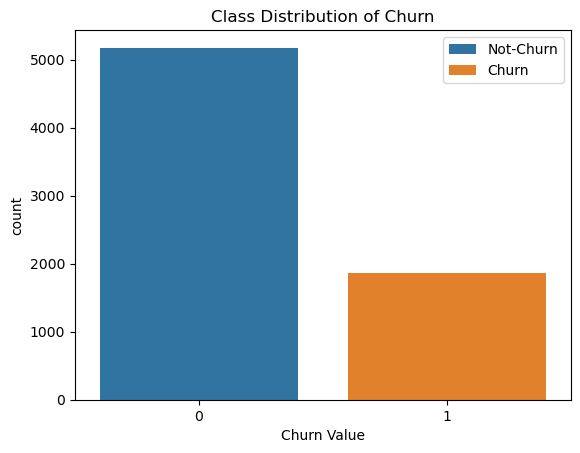

In [19]:
sns.countplot(x='Churn Value', data=df, label=['Not-Churn', 'Churn'])
plt.title("Class Distribution of Churn")
plt.legend()
plt.show()

We can see that there is a strong class imbalance between the two; therefore this data will need to be resampled; Using the SMOTE technique.